In [1]:
import os
import re
import pandas as pd
import numpy as np
import torch
from torch import optim
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder

In [2]:
# Функции подготовки датасета (посольку нам ничего не надо кроме координат джоинтов и лейблов - 
# - то имеет смысл все сильно упростить)
def get_files(path, files_to_exclude):
    files = []
    for filename in os.listdir(path):
        name, ext = os.path.splitext(filename)
        if 'skeleton' in ext and name not in files_to_exclude:
            camera_id, action_class = [int(x) for x in re.match(r'.*?C(\d+)?.*?A(\d+)?', name).groups()]
            if action_class in actions and camera_id in cameras:
                files.append([os.path.join(path, filename), action_class])
    return files

In [3]:
def read_xyz(file):
    f = open(file, 'r')
    num_frames = int(f.readline())
    data = np.zeros((2, num_frames, 25, 3))
    for frame in range(num_frames):
        for body in range(int(f.readline())):
            f.readline() # Body metadata
            for joint in range(int(f.readline())):
                data[body, frame, joint, :] = [float(x) for x in f.readline().split()[:3]]
    return data[[0]]

In [4]:
def form_dataset(path, files_to_exclude, chunk_size=45):
    train_data = []
    for file, label in get_files(path, files_to_exclude):
        data = read_xyz(file)
        if chunk_size <= data.shape[1]:
            train_data.append(np.append(data[:, :chunk_size, :, :].flatten(), [label], axis=0).tolist())
    return np.array(train_data)

In [5]:
%%time
# Подготовка данных
actions = [8, 10, 22, 23, 27, 21]
cameras = [1, 2, 3] 
LABELS = {8: 'sitting down', 21: 'take off a hat', 10: 'clapping', 22: 'cheer up', 23: 'hand waving', 27: 'jump up'}

base_path = 'c:/Users/Asus/Downloads/nturgbd_skeletons_s001_to_s017'

with open(os.path.join(base_path, 'missing_skels.txt'), 'r') as f:
    exceptions = [name for name in f.read().split('\n')]

data = form_dataset(os.path.join(base_path, 'nturgb+d_skeletons'), exceptions)

Wall time: 53.6 s


In [6]:
df = pd.DataFrame(data)
df.columns = [*df.columns[:-1], 'label']
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,label
0,-0.080141,0.135073,3.691227,-0.058513,0.396866,3.606265,-0.037811,0.652906,3.509790,-0.066903,...,-0.066586,-0.194186,3.880914,0.103226,-0.183070,3.717531,0.180819,-0.130425,3.724300,8.0
1,-0.035358,0.192430,3.681518,-0.021036,0.422171,3.606487,-0.007186,0.646429,3.520689,-0.042399,...,-0.247820,0.496547,3.406900,-0.056666,0.495373,3.269386,-0.050549,0.490788,3.258667,10.0
2,0.430001,0.024285,4.098490,0.424111,0.227365,4.005508,0.417157,0.427353,3.902021,0.395301,...,0.098534,0.515498,3.738000,0.243639,0.441711,3.635301,0.292146,0.468907,3.595111,21.0
3,0.399282,-0.026338,4.099298,0.382165,0.177244,4.002089,0.359935,0.376536,3.893836,0.338453,...,0.300487,0.700893,3.694455,0.535627,0.814146,3.868758,0.530421,0.797046,3.864750,22.0
4,0.424387,0.040135,4.204897,0.398431,0.244353,4.116918,0.373611,0.444495,4.016130,0.355235,...,0.183856,-0.074939,3.937576,0.369532,0.690305,3.718855,0.411135,0.633985,3.657250,23.0
5,0.284738,0.178680,3.764987,0.299845,0.428857,3.687624,0.314031,0.673921,3.600093,0.296217,...,-0.023884,1.059790,3.376500,0.302396,1.042522,3.275737,0.326857,0.969929,3.259500,27.0
6,0.259082,0.107407,3.673126,0.252590,0.379644,3.586978,0.246256,0.646283,3.491236,0.249200,...,0.196550,-0.061054,3.691182,0.210572,-0.118589,3.747635,0.195481,-0.115238,3.746909,8.0
7,0.294459,0.103630,3.653071,0.286122,0.375999,3.580207,0.277820,0.641571,3.499532,0.282940,...,0.426040,0.486630,3.321231,0.428990,0.531056,3.301848,0.384470,0.492621,3.310067,10.0
8,0.200731,0.208210,3.834275,0.180939,0.461690,3.756772,0.161220,0.709550,3.669313,0.183984,...,0.023829,0.919522,3.430600,0.256620,1.010221,3.579662,0.250573,0.966306,3.661500,21.0
9,0.161285,0.164668,3.766516,0.163123,0.415820,3.683940,0.164665,0.662383,3.591946,0.180526,...,0.059245,0.924142,3.273300,0.303597,0.970187,3.472500,0.301304,0.940344,3.463333,22.0


In [7]:
le = LabelEncoder()
le.fit(df.label)

LabelEncoder()

In [8]:
df.label = le.transform(df.label)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,label
0,-0.080141,0.135073,3.691227,-0.058513,0.396866,3.606265,-0.037811,0.652906,3.509790,-0.066903,...,-0.066586,-0.194186,3.880914,0.103226,-0.183070,3.717531,0.180819,-0.130425,3.724300,0
1,-0.035358,0.192430,3.681518,-0.021036,0.422171,3.606487,-0.007186,0.646429,3.520689,-0.042399,...,-0.247820,0.496547,3.406900,-0.056666,0.495373,3.269386,-0.050549,0.490788,3.258667,1
2,0.430001,0.024285,4.098490,0.424111,0.227365,4.005508,0.417157,0.427353,3.902021,0.395301,...,0.098534,0.515498,3.738000,0.243639,0.441711,3.635301,0.292146,0.468907,3.595111,2
3,0.399282,-0.026338,4.099298,0.382165,0.177244,4.002089,0.359935,0.376536,3.893836,0.338453,...,0.300487,0.700893,3.694455,0.535627,0.814146,3.868758,0.530421,0.797046,3.864750,3
4,0.424387,0.040135,4.204897,0.398431,0.244353,4.116918,0.373611,0.444495,4.016130,0.355235,...,0.183856,-0.074939,3.937576,0.369532,0.690305,3.718855,0.411135,0.633985,3.657250,4
5,0.284738,0.178680,3.764987,0.299845,0.428857,3.687624,0.314031,0.673921,3.600093,0.296217,...,-0.023884,1.059790,3.376500,0.302396,1.042522,3.275737,0.326857,0.969929,3.259500,5
6,0.259082,0.107407,3.673126,0.252590,0.379644,3.586978,0.246256,0.646283,3.491236,0.249200,...,0.196550,-0.061054,3.691182,0.210572,-0.118589,3.747635,0.195481,-0.115238,3.746909,0
7,0.294459,0.103630,3.653071,0.286122,0.375999,3.580207,0.277820,0.641571,3.499532,0.282940,...,0.426040,0.486630,3.321231,0.428990,0.531056,3.301848,0.384470,0.492621,3.310067,1
8,0.200731,0.208210,3.834275,0.180939,0.461690,3.756772,0.161220,0.709550,3.669313,0.183984,...,0.023829,0.919522,3.430600,0.256620,1.010221,3.579662,0.250573,0.966306,3.661500,2
9,0.161285,0.164668,3.766516,0.163123,0.415820,3.683940,0.164665,0.662383,3.591946,0.180526,...,0.059245,0.924142,3.273300,0.303597,0.970187,3.472500,0.301304,0.940344,3.463333,3


In [9]:
df.to_csv('data.csv', index=False)

In [10]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, frames=45, joints=25, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]
        self.frames = frames
        self.joints = joints

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx, :-1]).reshape(self.frames, self.joints * 3)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)
            
        return (item, label) 

In [11]:
dataset = Skeleton_Dataset(file_path = "data.csv")

In [12]:
df.shape

(5595, 3376)

In [13]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [5000,595])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [14]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [15]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[int(le.inverse_transform([labels[category_i]])[0])], category_i

In [16]:
# device = torch.device("cpu")

In [54]:
n_hidden, n_joints, n_layers = 128, 25, 2
lstm = LSTM_net(n_joints * 3, n_hidden, len(actions), n_layers)
lstm #.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [55]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.SGD(lstm.parameters(),lr=learning_rate,momentum=0.9)

In [56]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [57]:
torch.set_num_threads(16)

In [58]:
%%time
counter = 0
all_losses = []
for epoch in range(250):  
    current_loss = 0
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()
    
        output = lstm(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 

        current_loss += loss.item()
        category = LABELS[int(le.inverse_transform([labels[0]])[0])]
        
        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = f'{bcolors.OKGREEN}{bcolors.BOLD}True{bcolors.ENDC}' if guess == category else f'{bcolors.FAIL}{bcolors.BOLD}False {category}{bcolors.ENDC}'
            print(f'epoch : {epoch}, loss: {loss}, {guess}, {correct}')
        
        counter += 1
    all_losses.append(current_loss / 25)
    current_loss = 0

epoch : 0, loss: 1.765679121017456, cheer up, False jump up
epoch : 1, loss: 1.7818516492843628, take off a hat, False hand waving
epoch : 3, loss: 1.778734564781189, cheer up, False take off a hat
epoch : 4, loss: 1.7049288749694824, take off a hat, False cheer up
epoch : 6, loss: 1.5537452697753906, clapping, False cheer up
epoch : 7, loss: 1.366246223449707, jump up, True
epoch : 9, loss: 1.3047934770584106, take off a hat, True
epoch : 11, loss: 1.1647447347640991, hand waving, True
epoch : 12, loss: 1.2719475030899048, clapping, False sitting down
epoch : 14, loss: 1.1497029066085815, clapping, True
epoch : 15, loss: 1.463442087173462, cheer up, True
epoch : 17, loss: 1.328490972518921, cheer up, True
epoch : 19, loss: 1.122101902961731, jump up, True
epoch : 20, loss: 0.6572616100311279, sitting down, False hand waving
epoch : 22, loss: 0.7778241038322449, clapping, True
epoch : 23, loss: 1.1780792474746704, jump up, True
epoch : 25, loss: 1.5309274196624756, sitting down, True
e

epoch : 172, loss: 0.35386452078819275, take off a hat, False hand waving
epoch : 174, loss: 0.20153890550136566, jump up, True
epoch : 175, loss: 0.26263779401779175, take off a hat, False clapping
epoch : 177, loss: 0.2298382967710495, hand waving, False take off a hat
epoch : 178, loss: 0.1363229602575302, sitting down, True
epoch : 180, loss: 0.5040424466133118, cheer up, False jump up
epoch : 182, loss: 0.6009672284126282, cheer up, True
epoch : 183, loss: 0.5303344130516052, hand waving, False clapping
epoch : 185, loss: 0.3196927011013031, clapping, True
epoch : 186, loss: 0.384952187538147, cheer up, False jump up
epoch : 188, loss: 0.3999079465866089, take off a hat, False clapping
epoch : 190, loss: 0.3733561635017395, sitting down, True
epoch : 191, loss: 0.12126211822032928, sitting down, False hand waving
epoch : 193, loss: 0.27126559615135193, take off a hat, True
epoch : 194, loss: 0.29284539818763733, clapping, False cheer up
epoch : 196, loss: 0.3090674877166748, jump 

Вот реально - не знаю.. возможно точность и улучшается (по цифрам) - но аутпут результатов попаданий говорит об обратном :))

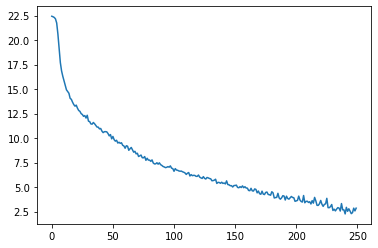

In [59]:
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

Я не против подбора параметров и конфигурации сети, это полезное занятие.. но 7 ЧАСОВ на тренировочный прогон - это такие себе перспективы лишится рабочей машины на ближайшие дни, поэтому заранее извиняюсь за отсутствие соответствующих экспериментов... 

In [60]:
%%time
# Подготовка данных
actions = [8, 10, 22, 23, 27, 21]
cameras = [1, 2, 3] 
LABELS = {8: 'sitting down', 21: 'take off a hat', 10: 'clapping', 22: 'cheer up', 23: 'hand waving', 27: 'jump up'}

base_path = 'c:/Users/Asus/Downloads/nturgbd_skeletons_s001_to_s017'

with open(os.path.join(base_path, 'missing_skels.txt'), 'r') as f:
    exceptions = [name for name in f.read().split('\n')]

data = form_dataset(os.path.join(base_path, 'nturgb+d_skeletons'), exceptions, chunk_size=30)

Wall time: 1min 52s


In [61]:
df = pd.DataFrame(data)
df.columns = [*df.columns[:-1], 'label']
le = LabelEncoder()
le.fit(df.label)
df.label = le.transform(df.label)
df.to_csv('data_30.csv', index=False)

In [62]:
dataset = Skeleton_Dataset(file_path="data_30.csv", frames=30)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [5000, 659])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [63]:
n_hidden, n_joints, n_layers = 128, 25, 2
lstm = LSTM_net(n_joints * 3, n_hidden, len(actions), n_layers)
lstm #.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [64]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.SGD(lstm.parameters(),lr=learning_rate,momentum=0.9)

In [65]:
%%time
counter = 0
all_losses = []
for epoch in range(250):  
    current_loss = 0
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()
    
        output = lstm(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 

        current_loss += loss.item()
        category = LABELS[int(le.inverse_transform([labels[0]])[0])]
        
        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = f'{bcolors.OKGREEN}{bcolors.BOLD}True{bcolors.ENDC}' if guess == category else f'{bcolors.FAIL}{bcolors.BOLD}False {category}{bcolors.ENDC}'
            print(f'epoch : {epoch}, loss: {loss}, {guess}, {correct}')
        
        counter += 1

    all_losses.append(current_loss / 25)
    current_loss = 0

epoch : 0, loss: 1.8003640174865723, sitting down, False clapping
epoch : 1, loss: 1.7897428274154663, take off a hat, True
epoch : 3, loss: 1.76266348361969, clapping, False take off a hat
epoch : 4, loss: 1.7603845596313477, cheer up, True
epoch : 6, loss: 1.5440261363983154, jump up, False cheer up
epoch : 7, loss: 1.4521044492721558, jump up, False take off a hat
epoch : 9, loss: 1.3277689218521118, jump up, True
epoch : 11, loss: 1.246718168258667, sitting down, True
epoch : 12, loss: 1.2395962476730347, cheer up, False clapping
epoch : 14, loss: 1.119511604309082, take off a hat, False hand waving
epoch : 15, loss: 1.234127402305603, jump up, False cheer up
epoch : 17, loss: 1.0680663585662842, take off a hat, False hand waving
epoch : 19, loss: 1.21255362033844, jump up, False clapping
epoch : 20, loss: 1.0577380657196045, cheer up, False hand waving
epoch : 22, loss: 1.0028297901153564, jump up, False hand waving
epoch : 23, loss: 0.9810354709625244, jump up, True
epoch : 25, l

epoch : 170, loss: 0.6742653250694275, sitting down, True
epoch : 172, loss: 0.41249099373817444, clapping, False jump up
epoch : 174, loss: 0.5283886194229126, jump up, False take off a hat
epoch : 175, loss: 0.8290917873382568, hand waving, False take off a hat
epoch : 177, loss: 0.4774629771709442, take off a hat, False jump up
epoch : 178, loss: 0.13614386320114136, sitting down, True
epoch : 180, loss: 0.2732778489589691, clapping, False hand waving
epoch : 182, loss: 0.6346302628517151, sitting down, True
epoch : 183, loss: 0.4100702702999115, clapping, False cheer up
epoch : 185, loss: 0.3069472312927246, jump up, False hand waving
epoch : 186, loss: 0.3383825719356537, cheer up, False clapping
epoch : 188, loss: 0.27384358644485474, cheer up, False take off a hat
epoch : 190, loss: 0.7125033140182495, take off a hat, False cheer up
epoch : 191, loss: 0.31337109208106995, jump up, False hand waving
epoch : 193, loss: 0.20496277511119843, sitting down, False clapping
epoch : 194,

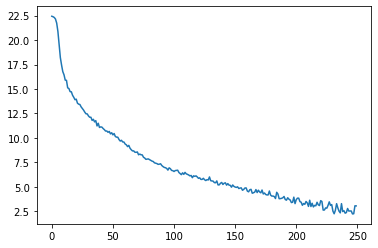

In [66]:
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [67]:
%%time
# Подготовка данных
actions = [8, 10, 22, 23, 27, 21]
cameras = [1, 2, 3] 
LABELS = {8: 'sitting down', 21: 'take off a hat', 10: 'clapping', 22: 'cheer up', 23: 'hand waving', 27: 'jump up'}

base_path = 'c:/Users/Asus/Downloads/nturgbd_skeletons_s001_to_s017'

with open(os.path.join(base_path, 'missing_skels.txt'), 'r') as f:
    exceptions = [name for name in f.read().split('\n')]

data = form_dataset(os.path.join(base_path, 'nturgb+d_skeletons'), exceptions, chunk_size=50)

Wall time: 55 s


In [68]:
df = pd.DataFrame(data)
df.columns = [*df.columns[:-1], 'label']
le = LabelEncoder()
le.fit(df.label)
df.label = le.transform(df.label)
df.to_csv('data_50.csv', index=False)

In [69]:
dataset = Skeleton_Dataset(file_path="data_50.csv", frames=50)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [5000, df.shape[0]-5000])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [70]:
n_hidden, n_joints, n_layers = 128, 25, 2
lstm = LSTM_net(n_joints * 3, n_hidden, len(actions), n_layers)
lstm #.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [71]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.SGD(lstm.parameters(),lr=learning_rate,momentum=0.9)

In [72]:
%%time
counter = 0
all_losses = []
for epoch in range(250):  
    current_loss = 0
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()
    
        output = lstm(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 

        current_loss += loss.item()
        category = LABELS[int(le.inverse_transform([labels[0]])[0])]
        
        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = f'{bcolors.OKGREEN}{bcolors.BOLD}True{bcolors.ENDC}' if guess == category else f'{bcolors.FAIL}{bcolors.BOLD}False {category}{bcolors.ENDC}'
            print(f'epoch : {epoch}, loss: {loss}, {guess}, {correct}')
        
        counter = counter + 1

    all_losses.append(current_loss / 25)
    current_loss = 0

epoch : 0, loss: 1.7840772867202759, clapping, False hand waving
epoch : 1, loss: 1.7840059995651245, sitting down, False jump up
epoch : 3, loss: 1.7674200534820557, jump up, False cheer up
epoch : 4, loss: 1.771883487701416, take off a hat, False hand waving
epoch : 6, loss: 1.487434983253479, cheer up, False hand waving
epoch : 7, loss: 1.495987892150879, jump up, True
epoch : 9, loss: 1.355911135673523, clapping, False cheer up
epoch : 11, loss: 1.1869878768920898, clapping, False cheer up
epoch : 12, loss: 0.9555477499961853, jump up, True
epoch : 14, loss: 1.1389546394348145, jump up, False cheer up
epoch : 15, loss: 1.2331767082214355, clapping, False hand waving
epoch : 17, loss: 0.9630536437034607, sitting down, True
epoch : 19, loss: 0.7709691524505615, take off a hat, False clapping
epoch : 20, loss: 1.2289412021636963, take off a hat, False jump up
epoch : 22, loss: 1.0548889636993408, clapping, False cheer up
epoch : 23, loss: 0.8825485110282898, jump up, False clapping
ep

epoch : 169, loss: 0.17625918984413147, take off a hat, False clapping
epoch : 170, loss: 0.31196868419647217, hand waving, True
epoch : 172, loss: 0.18258725106716156, take off a hat, False clapping
epoch : 174, loss: 0.3254082202911377, clapping, False jump up
epoch : 175, loss: 0.13122691214084625, sitting down, False clapping
epoch : 177, loss: 0.06839828938245773, cheer up, False clapping
epoch : 178, loss: 0.25869232416152954, jump up, True
epoch : 180, loss: 0.2919771373271942, clapping, False take off a hat
epoch : 182, loss: 0.06992063671350479, hand waving, True
epoch : 183, loss: 0.14071442186832428, cheer up, False hand waving
epoch : 185, loss: 0.19695501029491425, hand waving, True
epoch : 186, loss: 0.29859739542007446, take off a hat, False cheer up
epoch : 188, loss: 0.17882071435451508, sitting down, True
epoch : 190, loss: 0.2827450931072235, hand waving, False jump up
epoch : 191, loss: 0.11630795150995255, sitting down, False hand waving
epoch : 193, loss: 0.481400

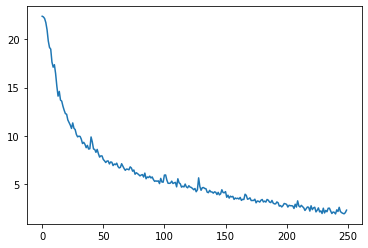

In [73]:
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

### Итог
(если это можно так назвать...) 
- Учить такую сетку неимоверно долго
- Точность по приборам улучшается довольно равномерно (главное подобрать learning rate)
- На 45 и 30 кадровых секвенциях результат видится примерно одинаковым
- На 50 кадровых последовательностях обучение идет хуже (медленнее) (надо было эти графики вместе отрисовать - но я этот момент упустил и писал все в один и тот же список, а теперь тренировать заново, куча времени)

Что однако не значит что нельзя достичь лучшего скора потренировавшись еще (по всем графикам видно, что мы недообучены на 250 эпохах. Учить дольше - для меня слишком затратно по времени. Куды - нет (Radeon). Учить быстрее - не получается - при выставлении большего learning rate обучение просто не происходит.. loss не падает вообще - стоит в районе 1.78, что в моем понимании довольно странно - обычно при большой скорости обучения мы должны наблюдать скачки loss-а вниз-вверх, как бы вход в резонанс, но тут почему-то я видел просто - небольшие около +-1e04 отклонения от фиксированного значения. Загадка. Но на форумах пишут, что это проблема неправильно подобранной скорости. 

Вобщем, первые эксперименты. Начинаем потихоньку привыкать к особенностям..